In [1]:
import cv2
import numpy as np
import os
import pandas as pd
from configparser import ConfigParser
from generator import AugmentedImageSequence
# from models.keras import ModelFactory
from keras import backend as kb
from keras.layers import Dense
from keras.applications.densenet import DenseNet121  # Import DenseNet model
from keras.models import Model  # Import Model from Keras

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer


def create_cam(df_g, output_dir, image_source_dir, model, generator, class_names):
    file_name = df_g["file_name"]
    print(f"process image: {file_name}")

    # draw bbox with labels
    img_ori = cv2.imread(filename=os.path.join(image_source_dir, file_name))

    label = df_g["label"]
    if label == "Infiltrate":
        label = "Infiltration"
    index = class_names.index(label)

    output_path = os.path.join(output_dir, f"{label}.{file_name}")

    img_transformed = generator.load_image(file_name)

    # CAM overlay
    # Get the 512 input weights to the softmax.
    class_weights = model.layers[-1].get_weights()[0]
    final_conv_layer = get_output_layer(model, "bn")
    # print(model.summary())
    get_output = kb.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([np.array([img_transformed])])
    # print("Prediction is: ",np.argmax(predictions))
    conv_outputs = conv_outputs[0, :, :, :]

    # Create the class activation map.
    cam = np.zeros(dtype=np.float32, shape=(conv_outputs.shape[:2]))
    for i, w in enumerate(class_weights[index]):
        cam += w * conv_outputs[:, :, i]
    # print(f"predictions: {predictions}")
    cam /= np.max(cam)
    cam = cv2.resize(cam, img_ori.shape[:2])
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam < 0.2)] = 0

    # Resize heatmap to match the shape of img_ori
    heatmap_resized = cv2.resize(heatmap, (img_ori.shape[1], img_ori.shape[0]))
    img = heatmap_resized * 0.5 + img_ori

    # add label & rectangle
    # ratio = output dimension / 1024
    ratio = 1
    x1 = int(df_g["x"] * ratio)
    y1 = int(df_g["y"] * ratio)
    x2 = int((df_g["x"] + df_g["w"]) * ratio)
    y2 = int((df_g["y"] + df_g["h"]) * ratio)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(img, text=label, org=(5, 20), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.8, color=(0, 0, 255), thickness=1)
    cv2.imwrite(output_path, img)


def main():
    # parser config
    config_file = "./config.ini"
    cp = ConfigParser()
    cp.read(config_file)

    # default config
    output_dir = cp["DEFAULT"].get("output_dir")
    base_model_name = cp["DEFAULT"].get("base_model_name")
    class_names = cp["DEFAULT"].get("class_names").split(",")
    image_source_dir = cp["DEFAULT"].get("image_source_dir")
    image_dimension = cp["TRAIN"].getint("image_dimension")

    # parse weights file path
    output_weights_name = cp["TRAIN"].get("output_weights_name")
    weights_path = os.path.join(output_dir, output_weights_name)
    best_weights_path = os.path.join(output_dir, f"best_{output_weights_name}")

    # CAM config
    bbox_list_file = cp["CAM"].get("bbox_list_file")
    use_best_weights = cp["CAM"].getboolean("use_best_weights")
    
    print("** load model **")
    if use_best_weights:
        print("** use best weights **")
        model_weights_path = best_weights_path
    else:
        print("** use last weights **")
        model_weights_path = weights_path

    # Load DenseNet model
    base_model = DenseNet121(weights=None, include_top=False, input_shape=(image_dimension, image_dimension, 3))
    x = base_model.output
    x = Dense(len(class_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)

    # Load weights into the model
    model.load_weights(model_weights_path)

    print("read bbox list file")
    df_images = pd.read_csv(bbox_list_file, header=None, skiprows=1)
    df_images.columns = ["file_name", "label", "x", "y", "w", "h"]

    print("create a generator for loading transformed images")
    cam_sequence = AugmentedImageSequence(
        dataset_csv_file=os.path.join(output_dir, "test.csv"),
        class_names=class_names,
        source_image_dir=image_source_dir,
        batch_size=1,
        target_size=(image_dimension, image_dimension),
        augmenter=None,
        steps=1,
        shuffle_on_epoch_end=False,
    )

    image_output_dir = os.path.join(output_dir, "cam")
    if not os.path.isdir(image_output_dir):
        os.makedirs(image_output_dir)

    print("create CAM-output.")
    # print("create CAM-input.")
    df_images.apply(
        lambda g: create_cam(
            df_g=g,
            output_dir=image_output_dir,
            image_source_dir=image_source_dir,
            model=model,
            generator=cam_sequence,
            class_names=class_names,
        ),
        axis=1,
    )



if __name__ == "__main__":
    main()



** load model **
** use best weights **


read bbox list file
create a generator for loading transformed images
create CAM-output.
process image: 00010277_000.png
process image: 00011366_002.png
process image: 00010120_010.png
process image: 00005869_001.png
process image: 00002980_000.png
process image: 00008291_009.png
process image: 00003789_000.png
process image: 00003528_024.png
process image: 00010610_003.png
process image: 00003028_006.png
process image: 00009107_006.png
process image: 00010447_018.png
process image: 00003391_001.png
process image: CXR3724_IM-1860-1001_Report_pnuemo.png


In [2]:
import csv
import os
import cv2
from IPython.display import display, Image, HTML
def load_csv(csv_file):
    data = []
    with open(csv_file, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            data.append(row)
    return data

def display_images(image_data, original_folder, cam_folder, output_folder):
    for entry in image_data:
        image_index = entry['Image Index']
        original_path = os.path.join(original_folder, image_index)
        cam_image_index = "Pneumonia." + image_index
        cam_path = os.path.join(cam_folder, cam_image_index)

        if os.path.exists(original_path) and os.path.exists(cam_path):
            original_image = cv2.imread(original_path)
            cam_image = cv2.imread(cam_path)

            if original_image is not None and cam_image is not None:
                side_by_side = cv2.hconcat([original_image, cam_image])
                output_path = os.path.join(output_folder, f"{image_index}_comparison.jpg")
                cv2.imwrite(output_path, side_by_side)
                print(f"Saved comparison image for {image_index}")
                
            else:
                print(f"Error: Could not read images for {image_index}")
        else:
            print(f"Error: Image not found for {image_index}")

def main(csv_file, original_folder, cam_folder, output_folder):
    image_data = load_csv(csv_file)
    display_images(image_data, original_folder, cam_folder, output_folder)

if __name__ == "__main__":
    csv_file = r"D:\Tapasvi\Projects\Main_Project\CheXNet- Final for gradcam\CheXNet-Keras-master\data\filtered_data.csv"
    original_folder = r"D:\Tapasvi\Projects\Main_Project\CheXNet- Final for gradcam\CheXNet-Keras-master\data\images"
    cam_folder = r"D:\Tapasvi\Projects\Main_Project\CheXNet- Final for gradcam\CheXNet-Keras-master\experiments\1\cam"
    output_folder = r"D:\Tapasvi\Projects\Main_Project\CheXNet- Final for gradcam\CheXNet-Keras-master\output"
    main(csv_file, original_folder, cam_folder, output_folder)


Saved comparison image for 00010277_000.png
Saved comparison image for 00011366_002.png
Saved comparison image for 00010120_010.png
Saved comparison image for 00005869_001.png
Saved comparison image for 00002980_000.png
Saved comparison image for 00008291_009.png
Saved comparison image for 00003789_000.png
Saved comparison image for 00003528_024.png
Saved comparison image for 00010610_003.png
Saved comparison image for 00003028_006.png
Saved comparison image for 00009107_006.png
Saved comparison image for 00010447_018.png
Saved comparison image for 00003391_001.png
Saved comparison image for CXR3724_IM-1860-1001_Report_pnuemo.png


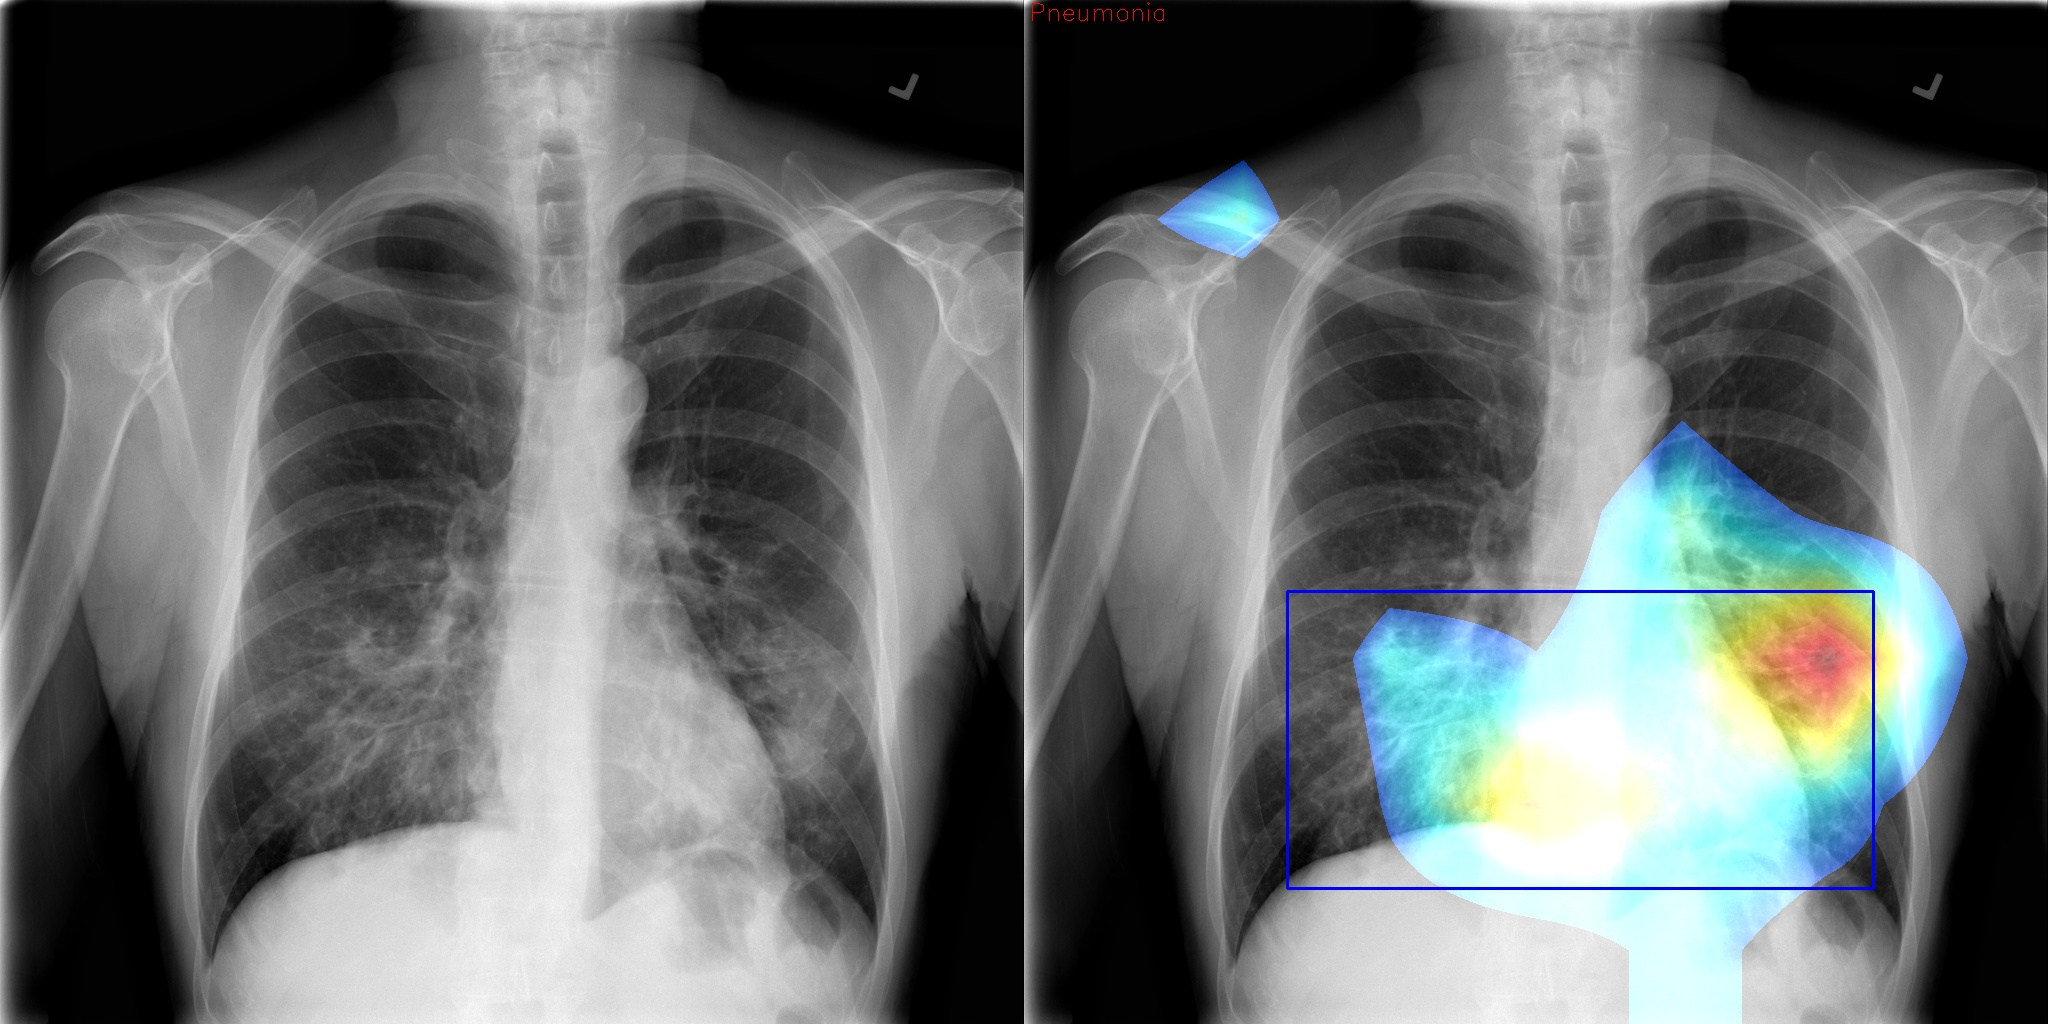

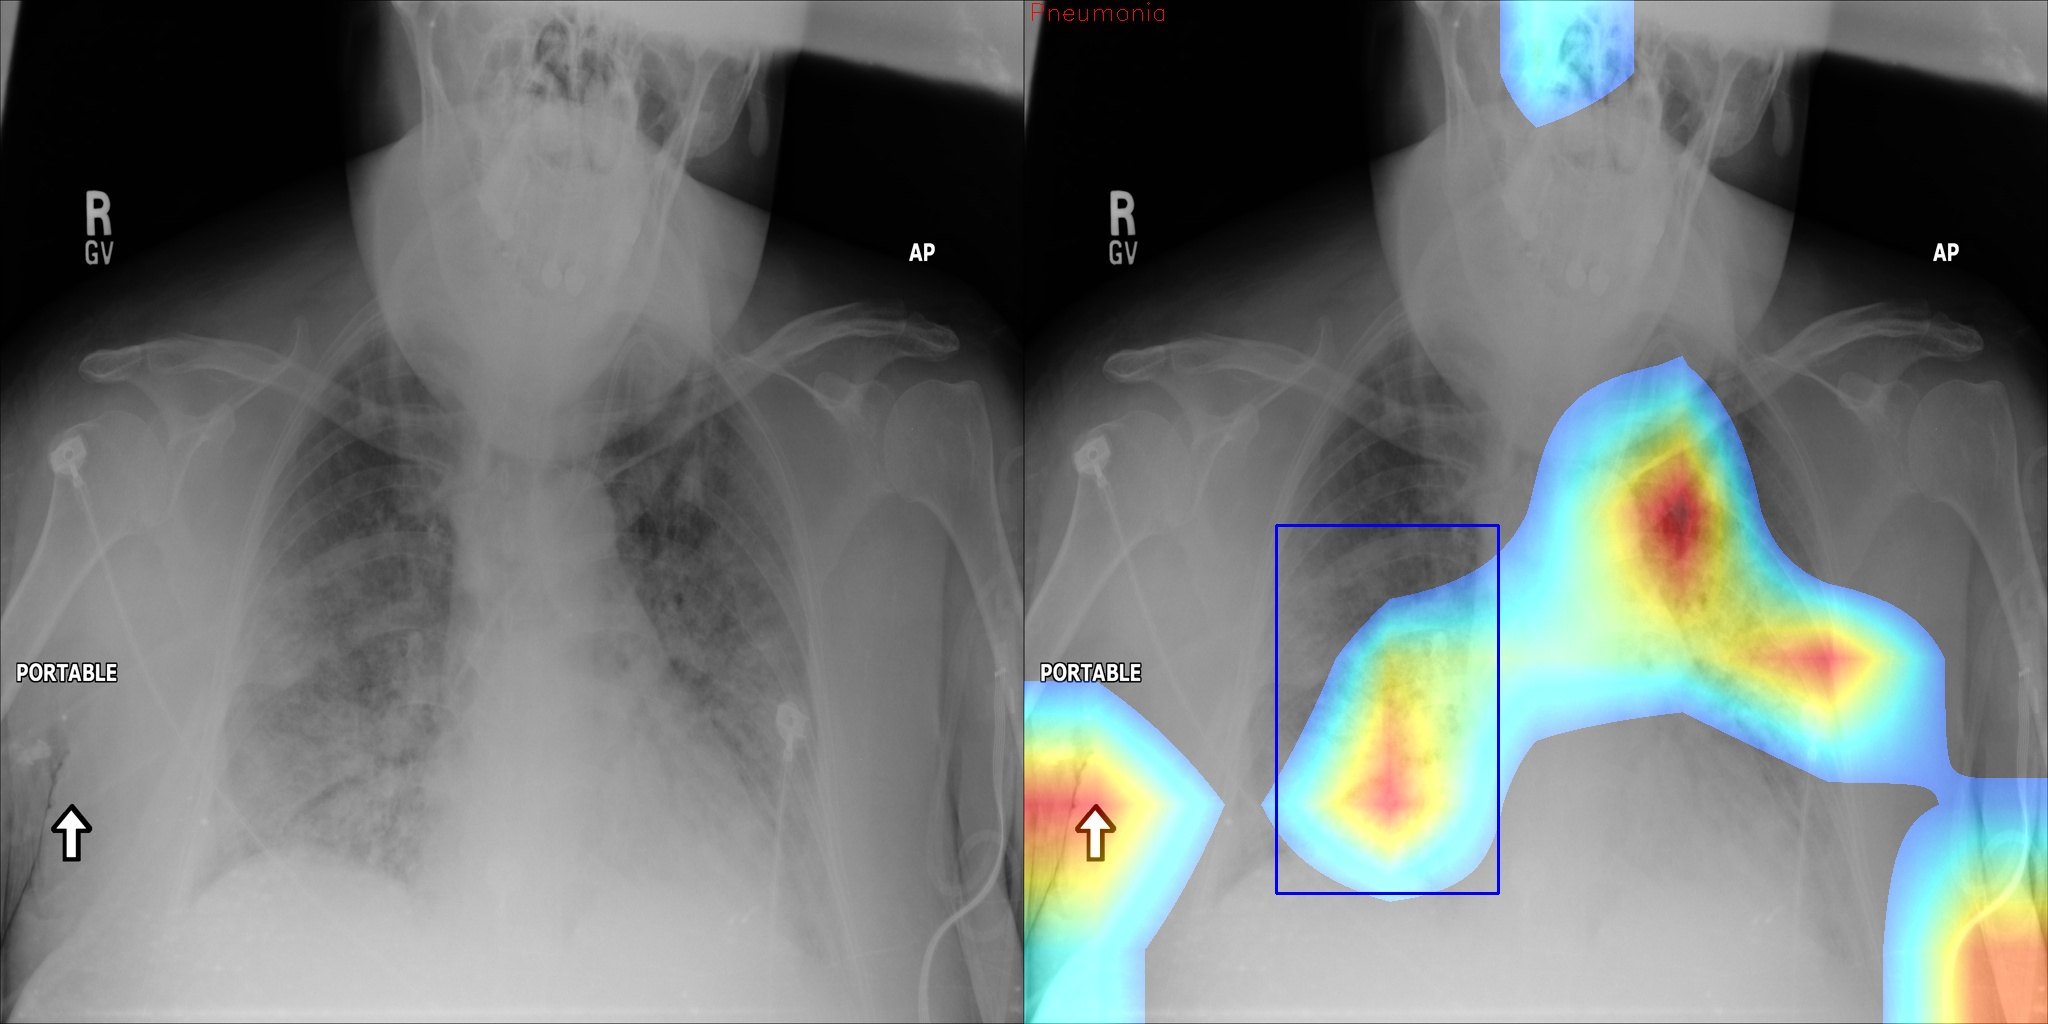

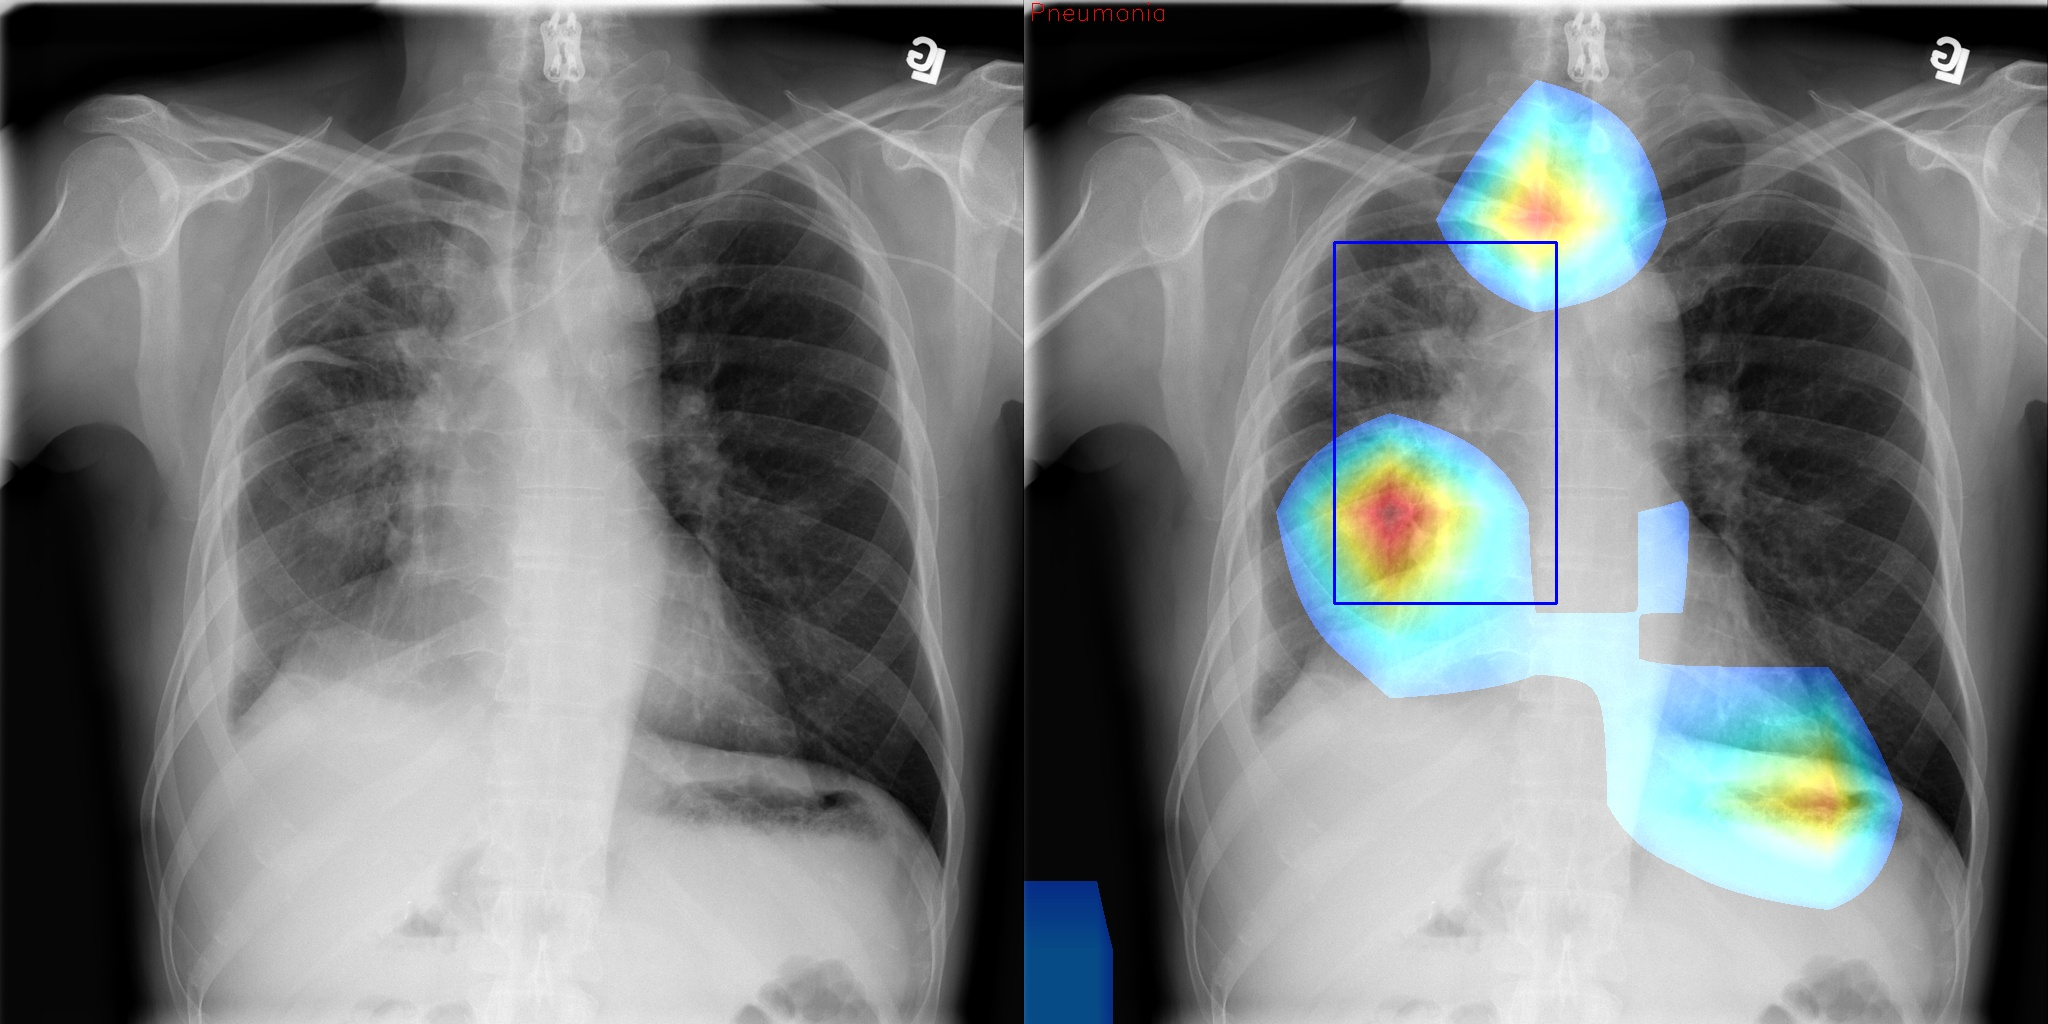

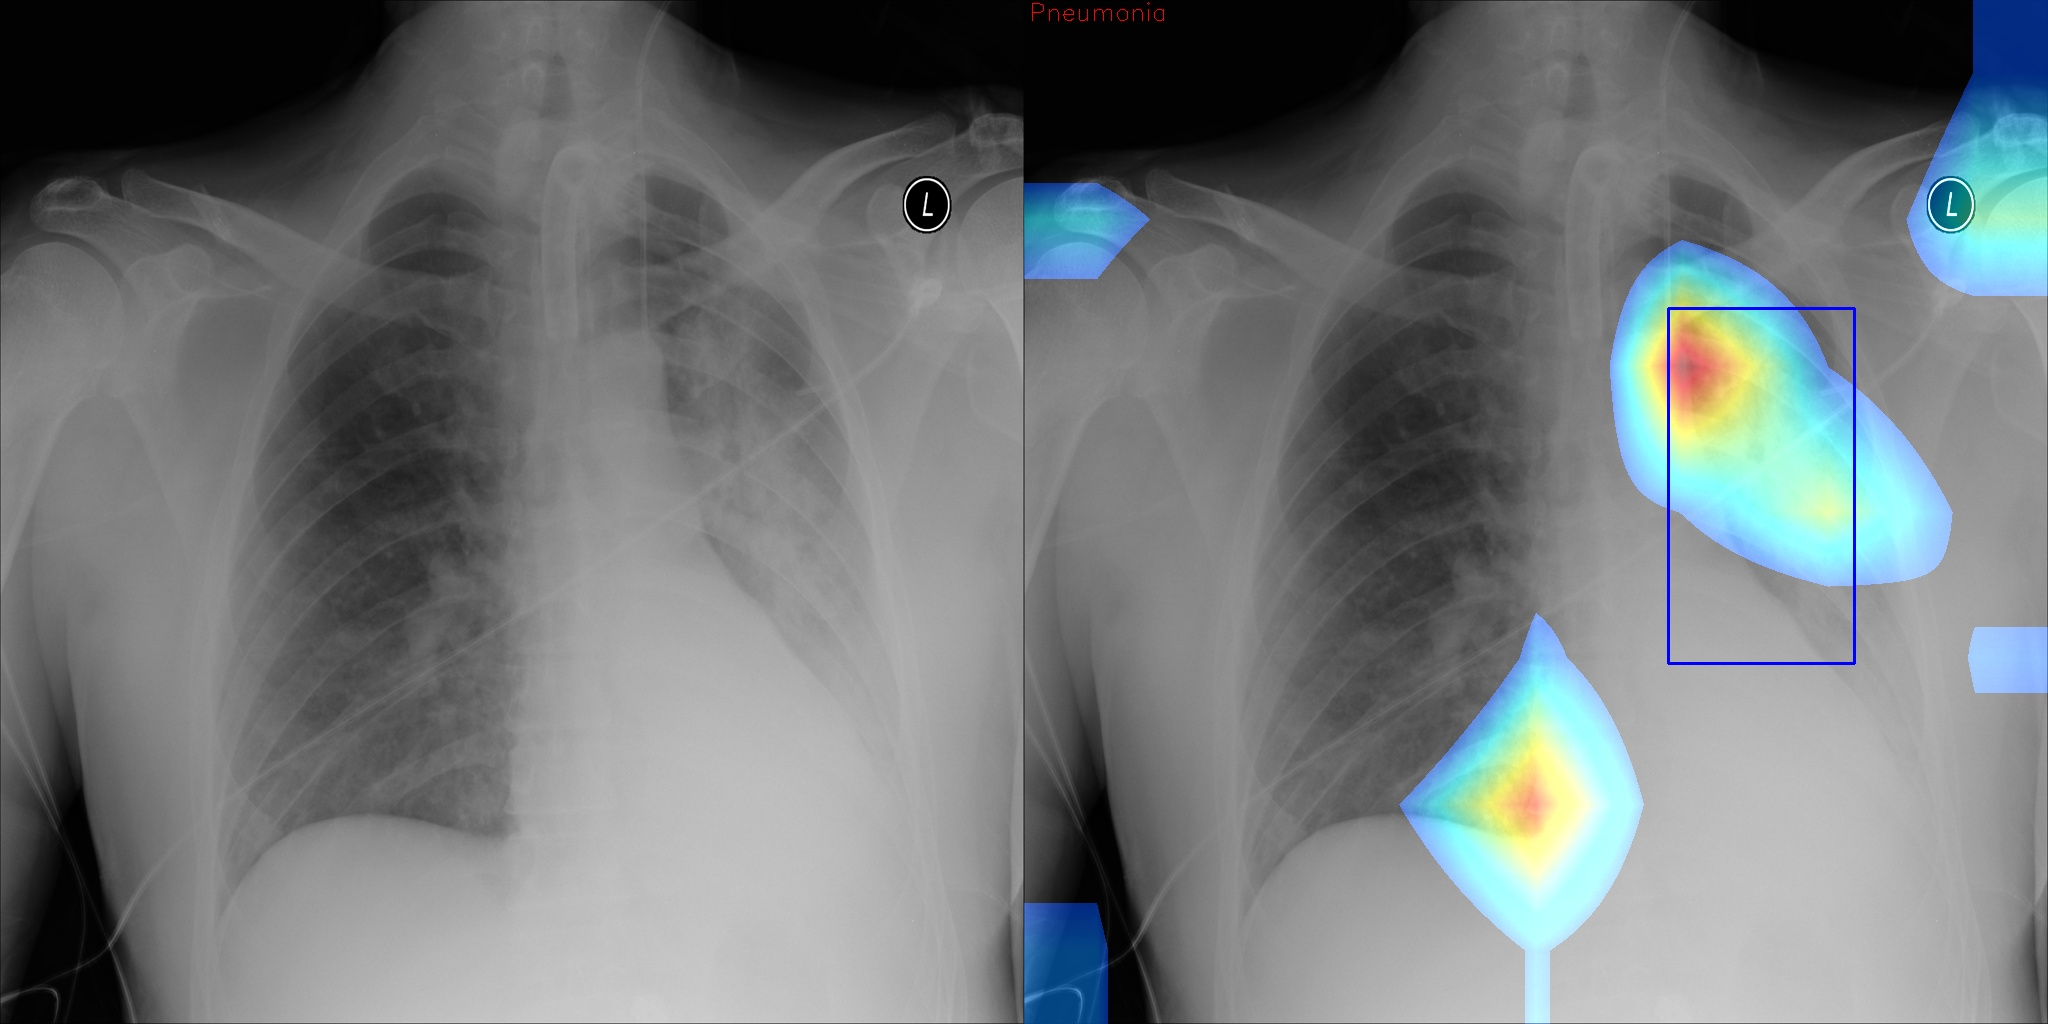

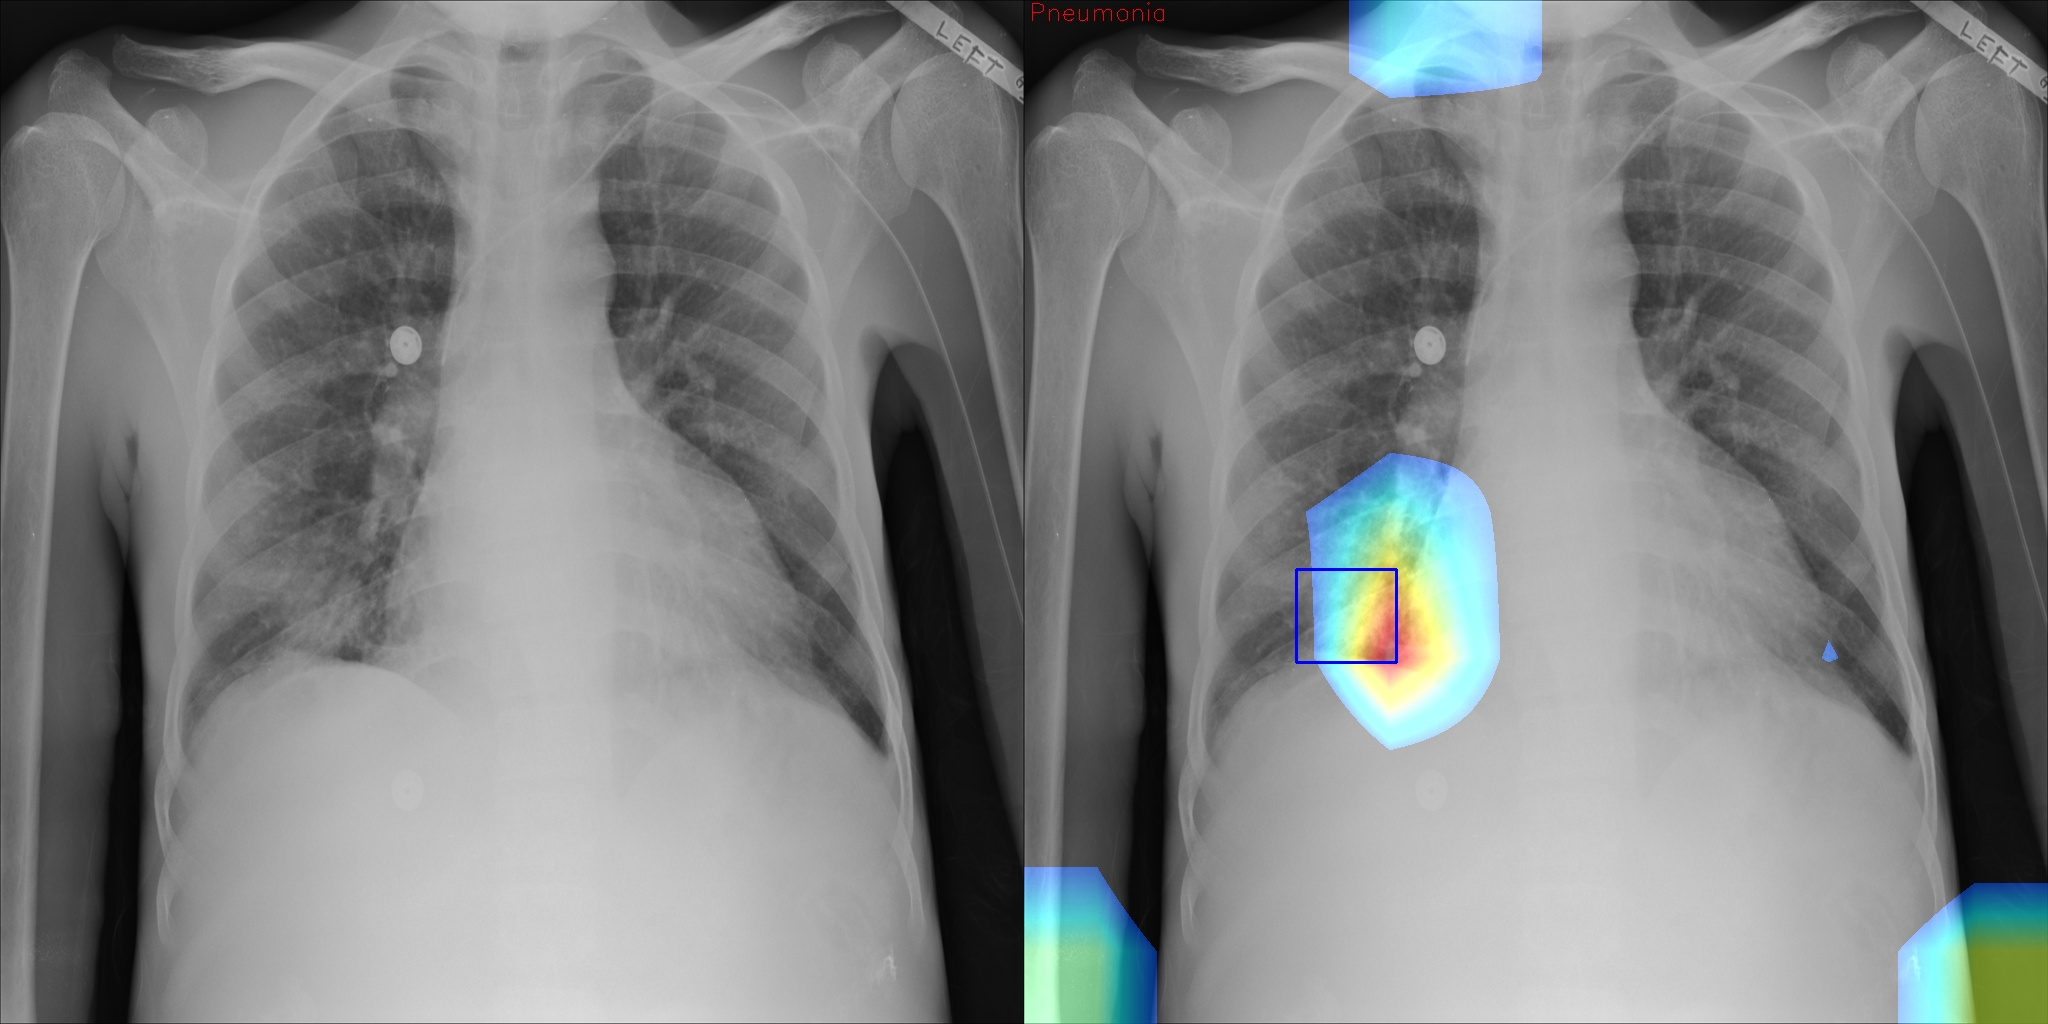

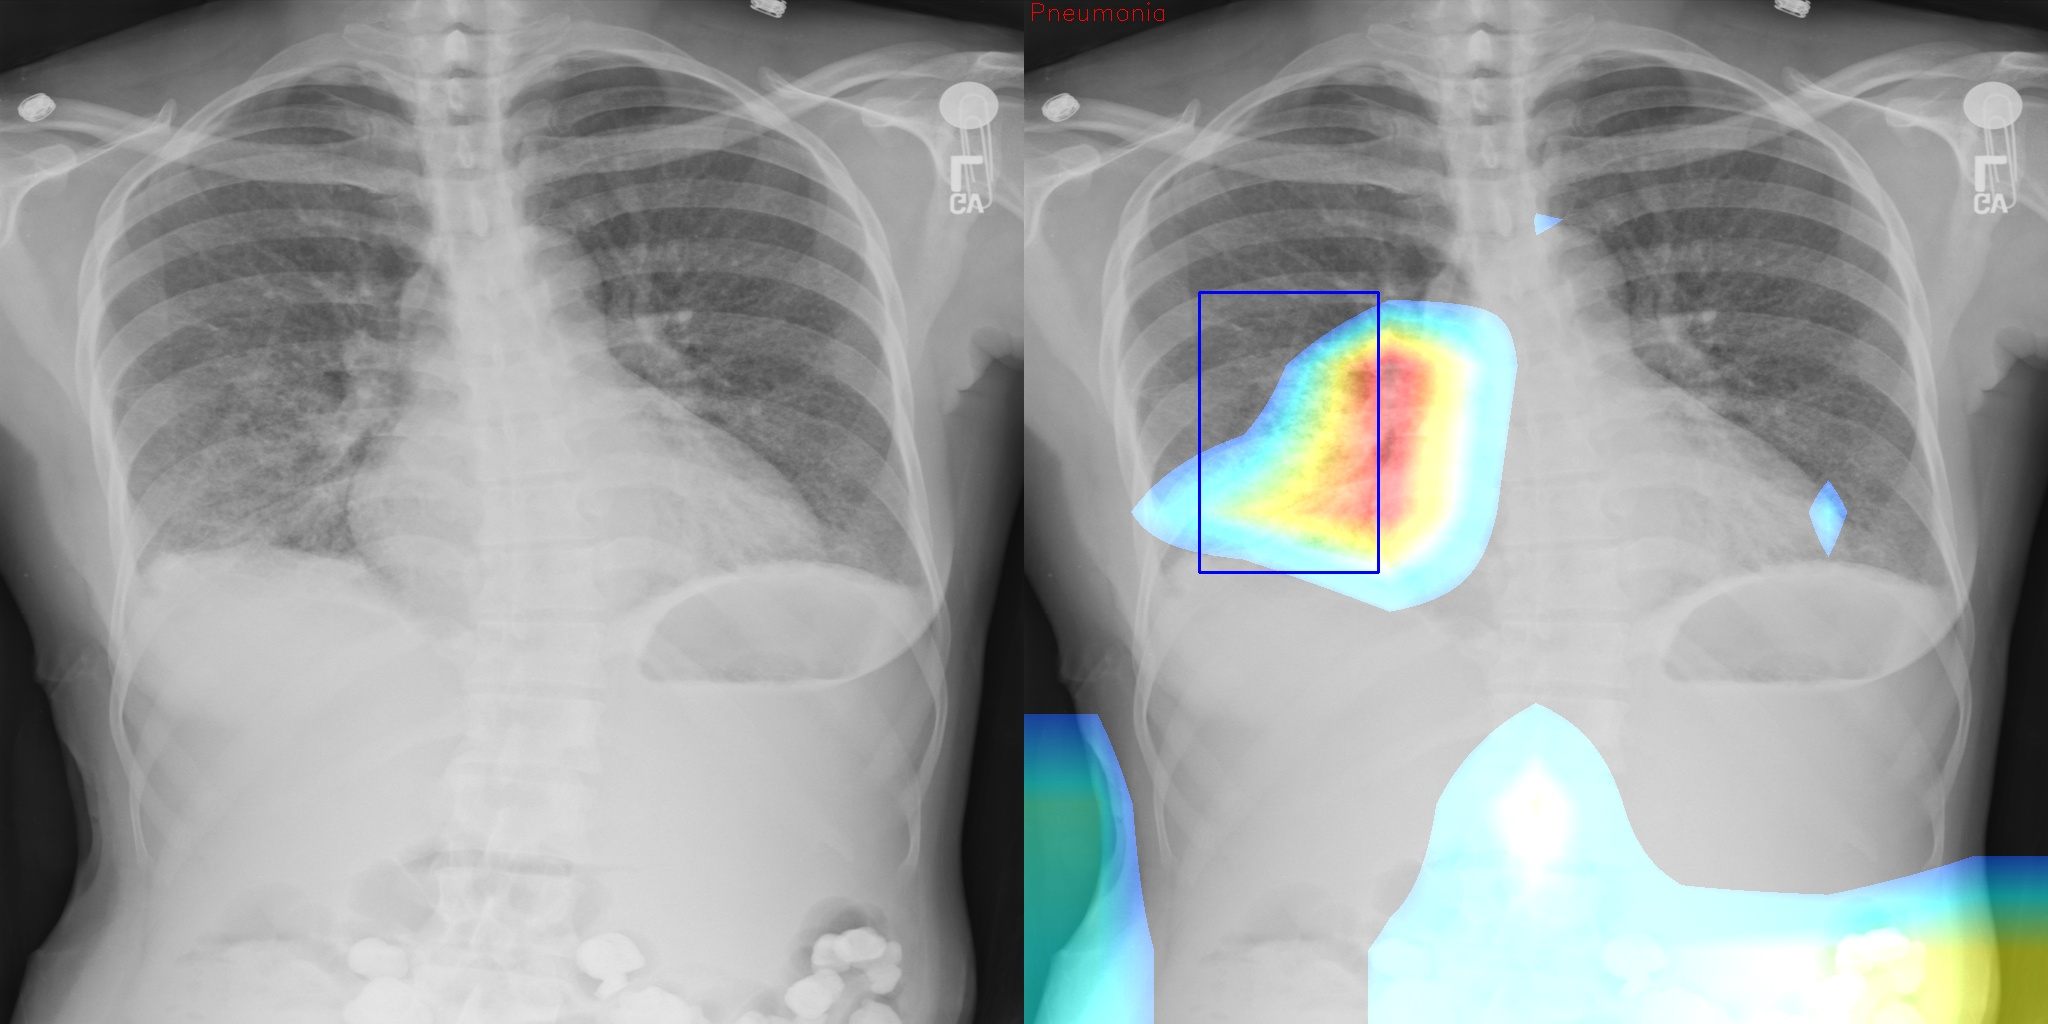

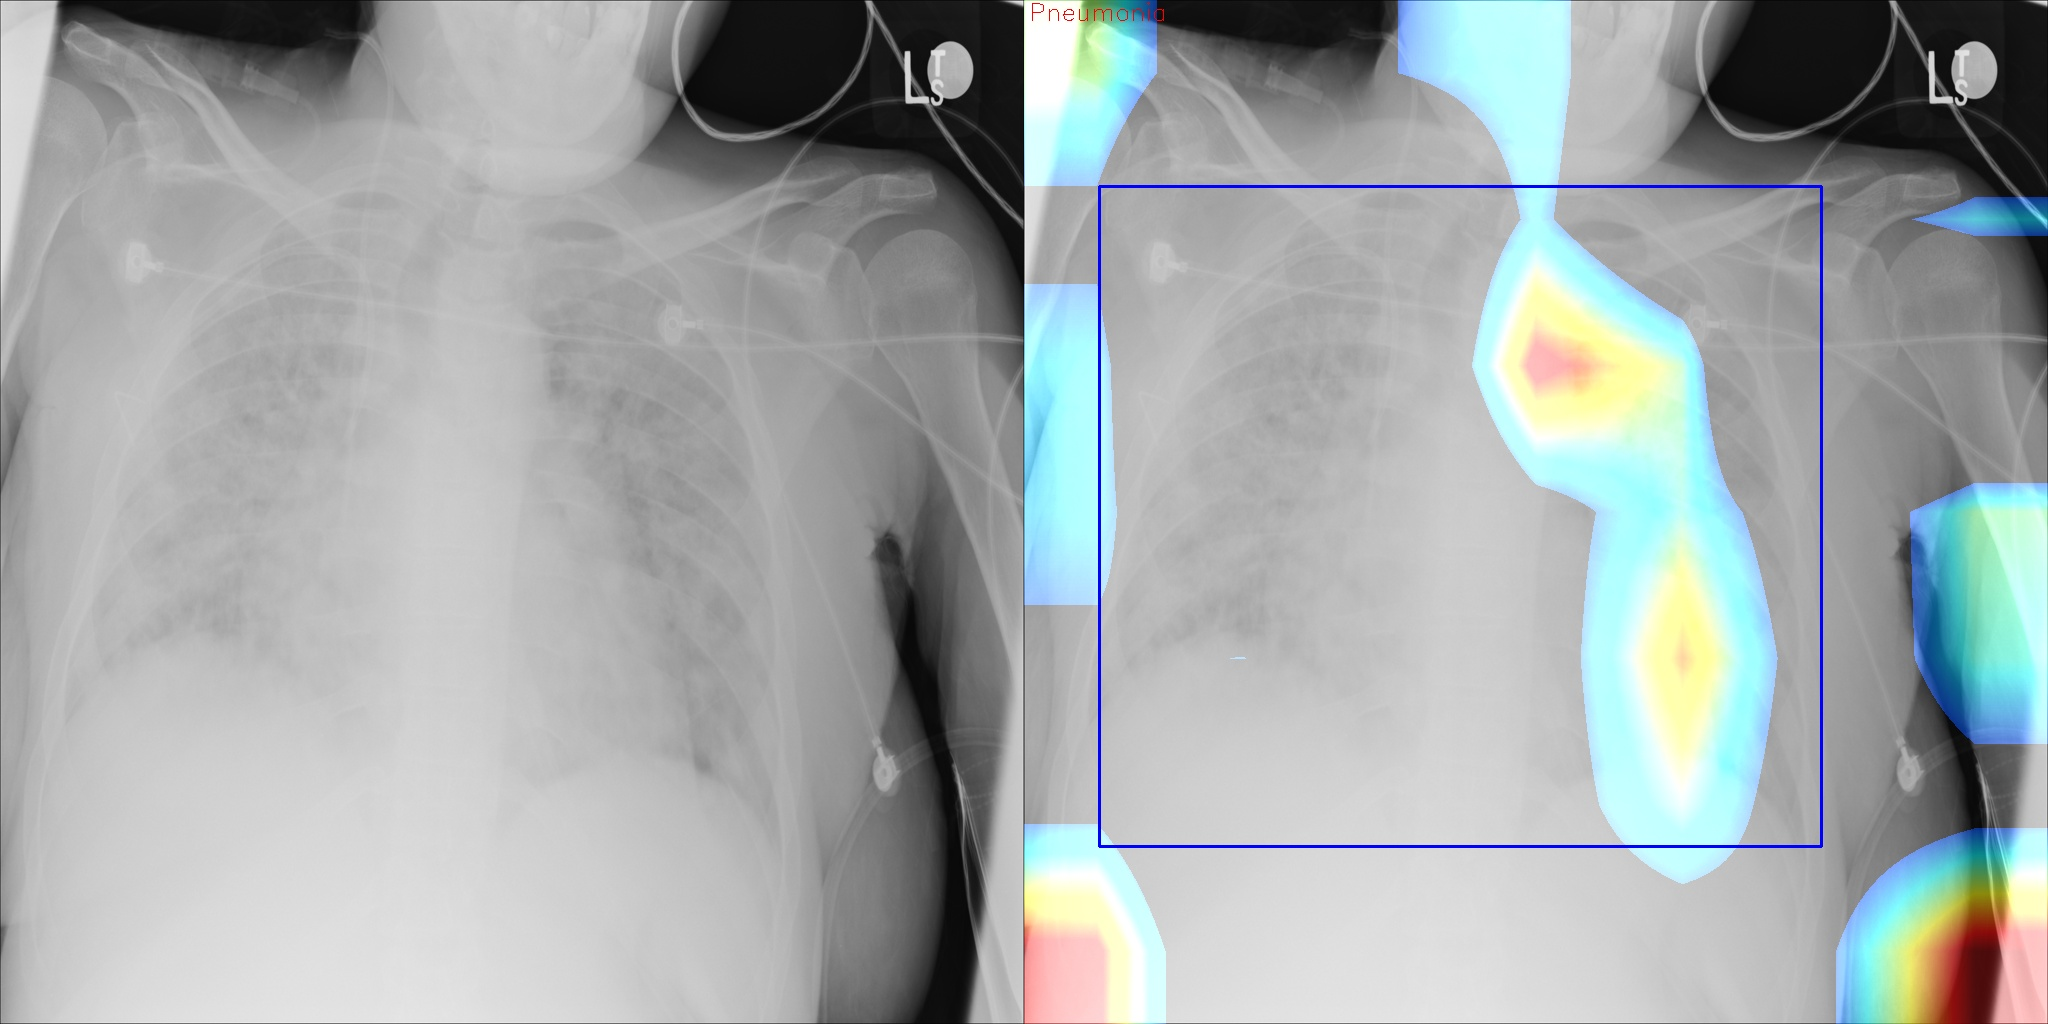

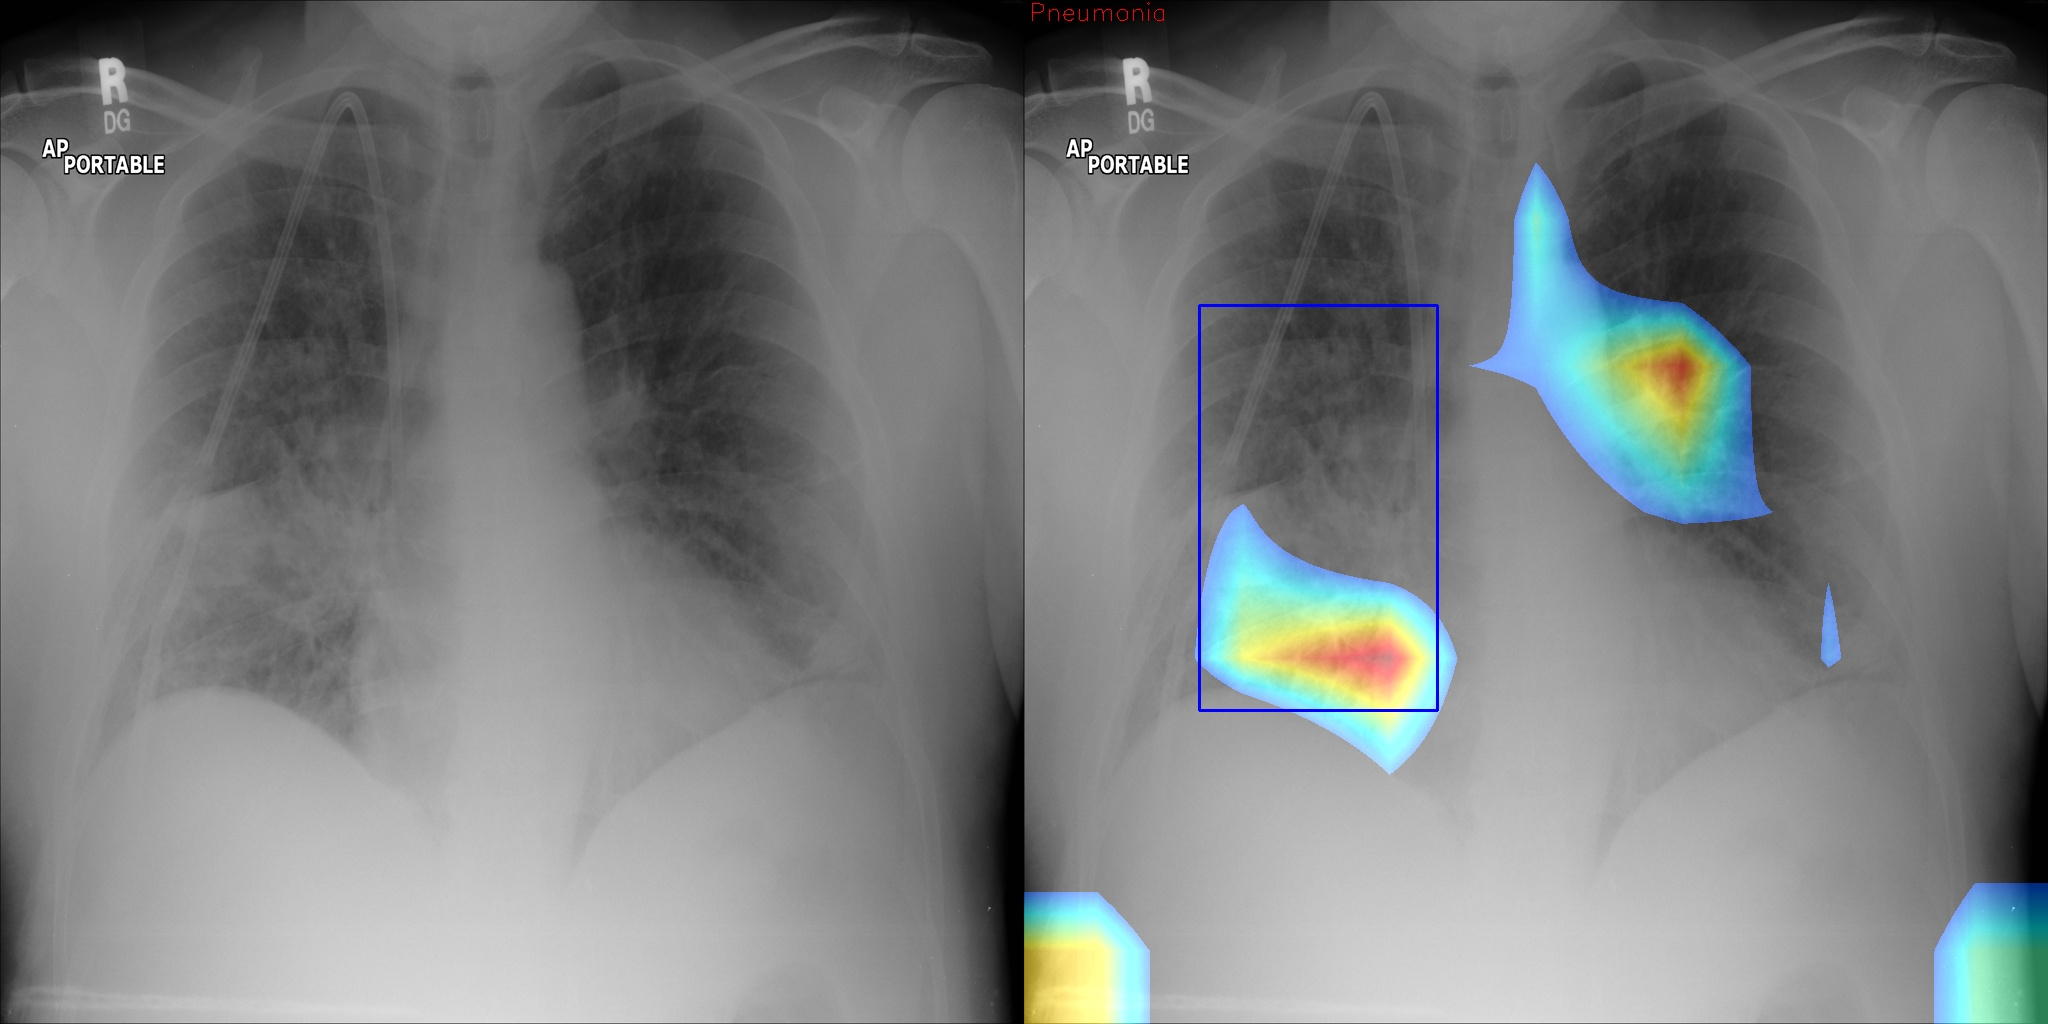

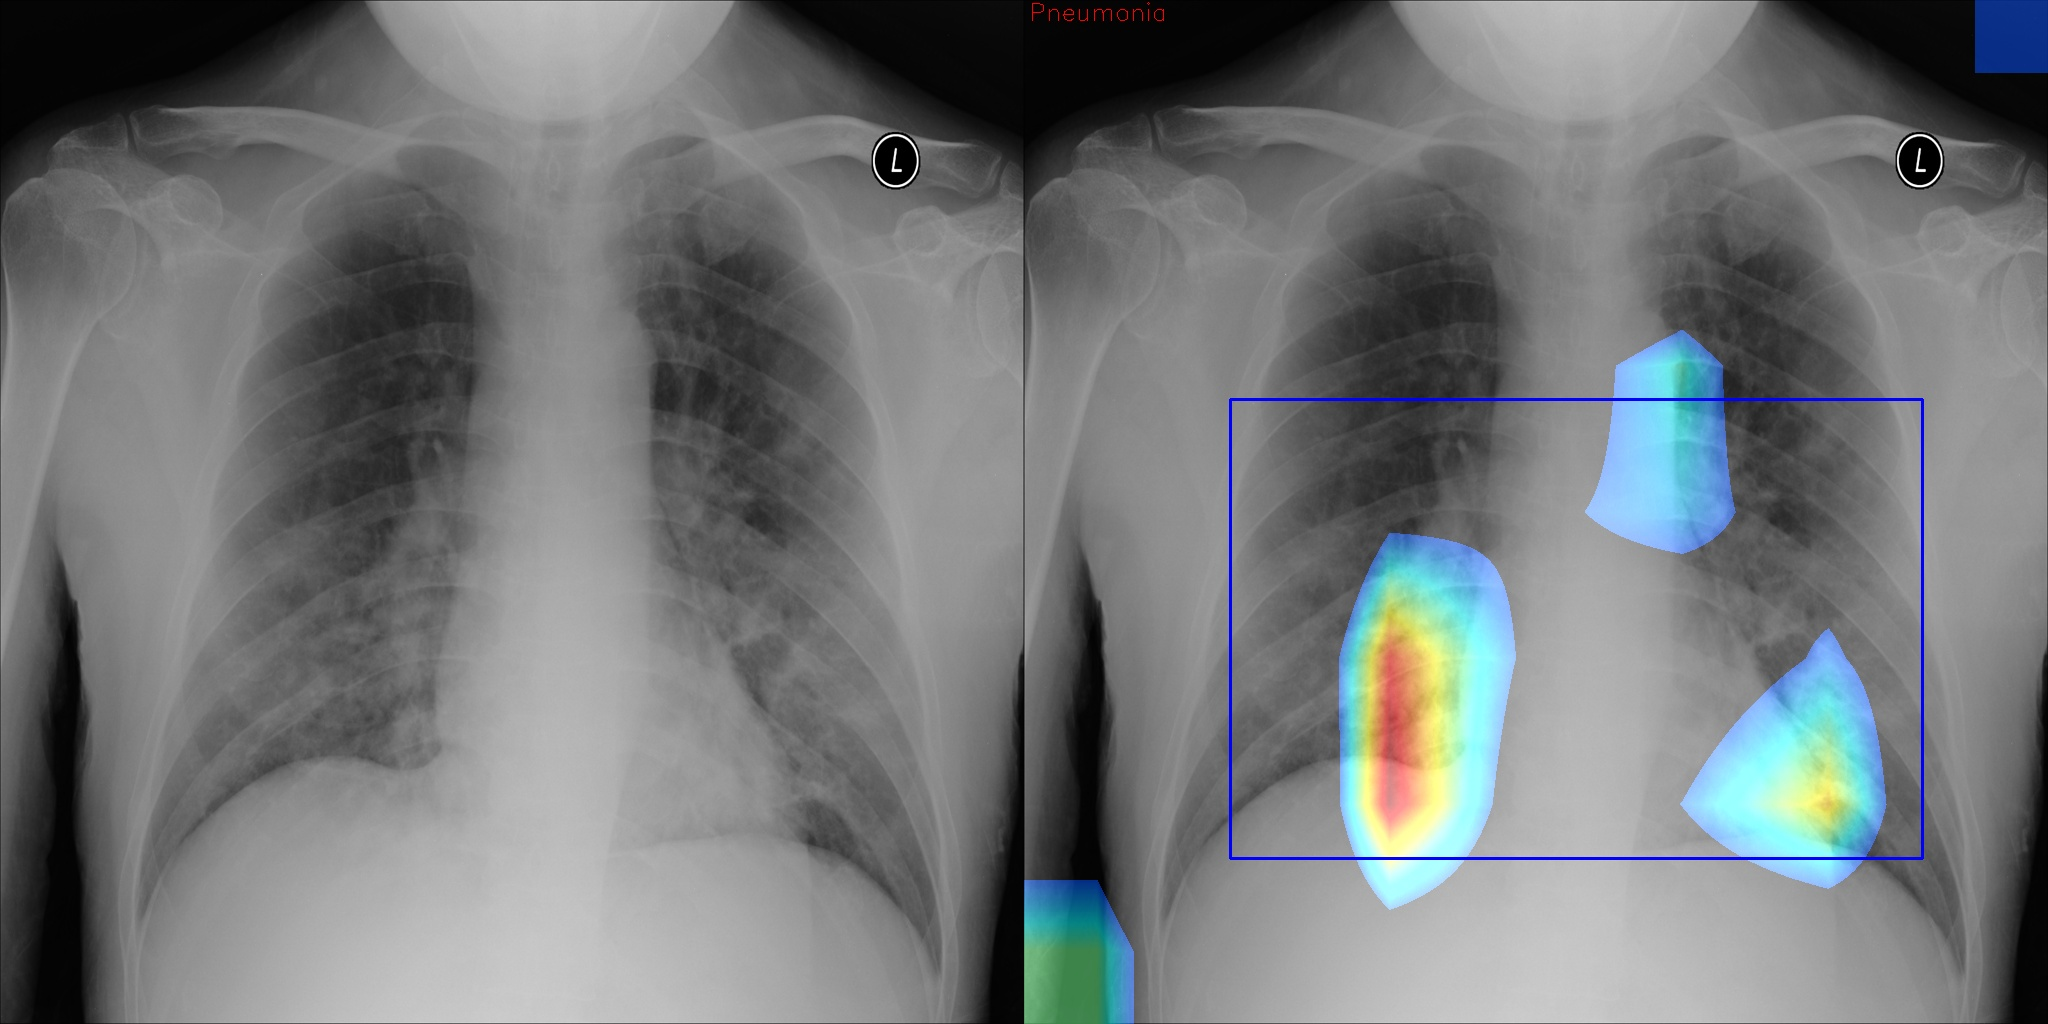

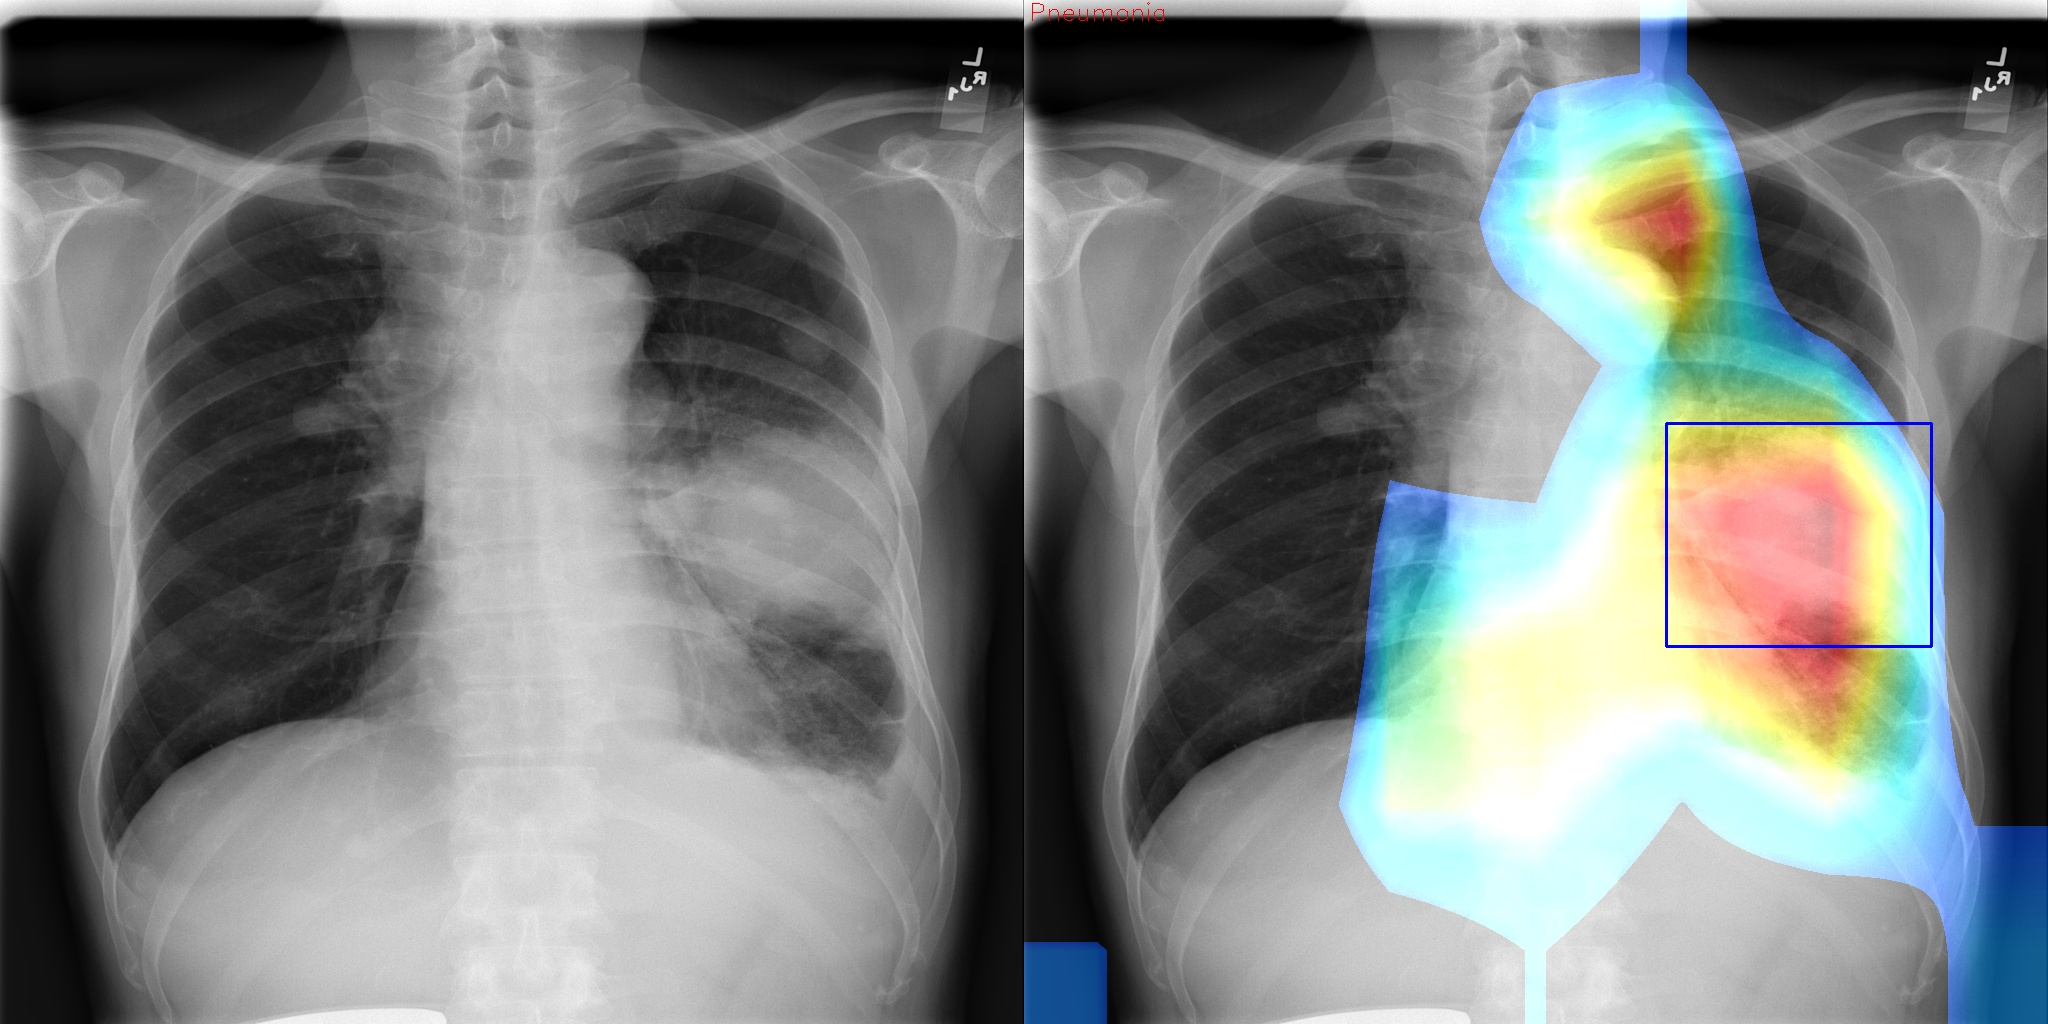

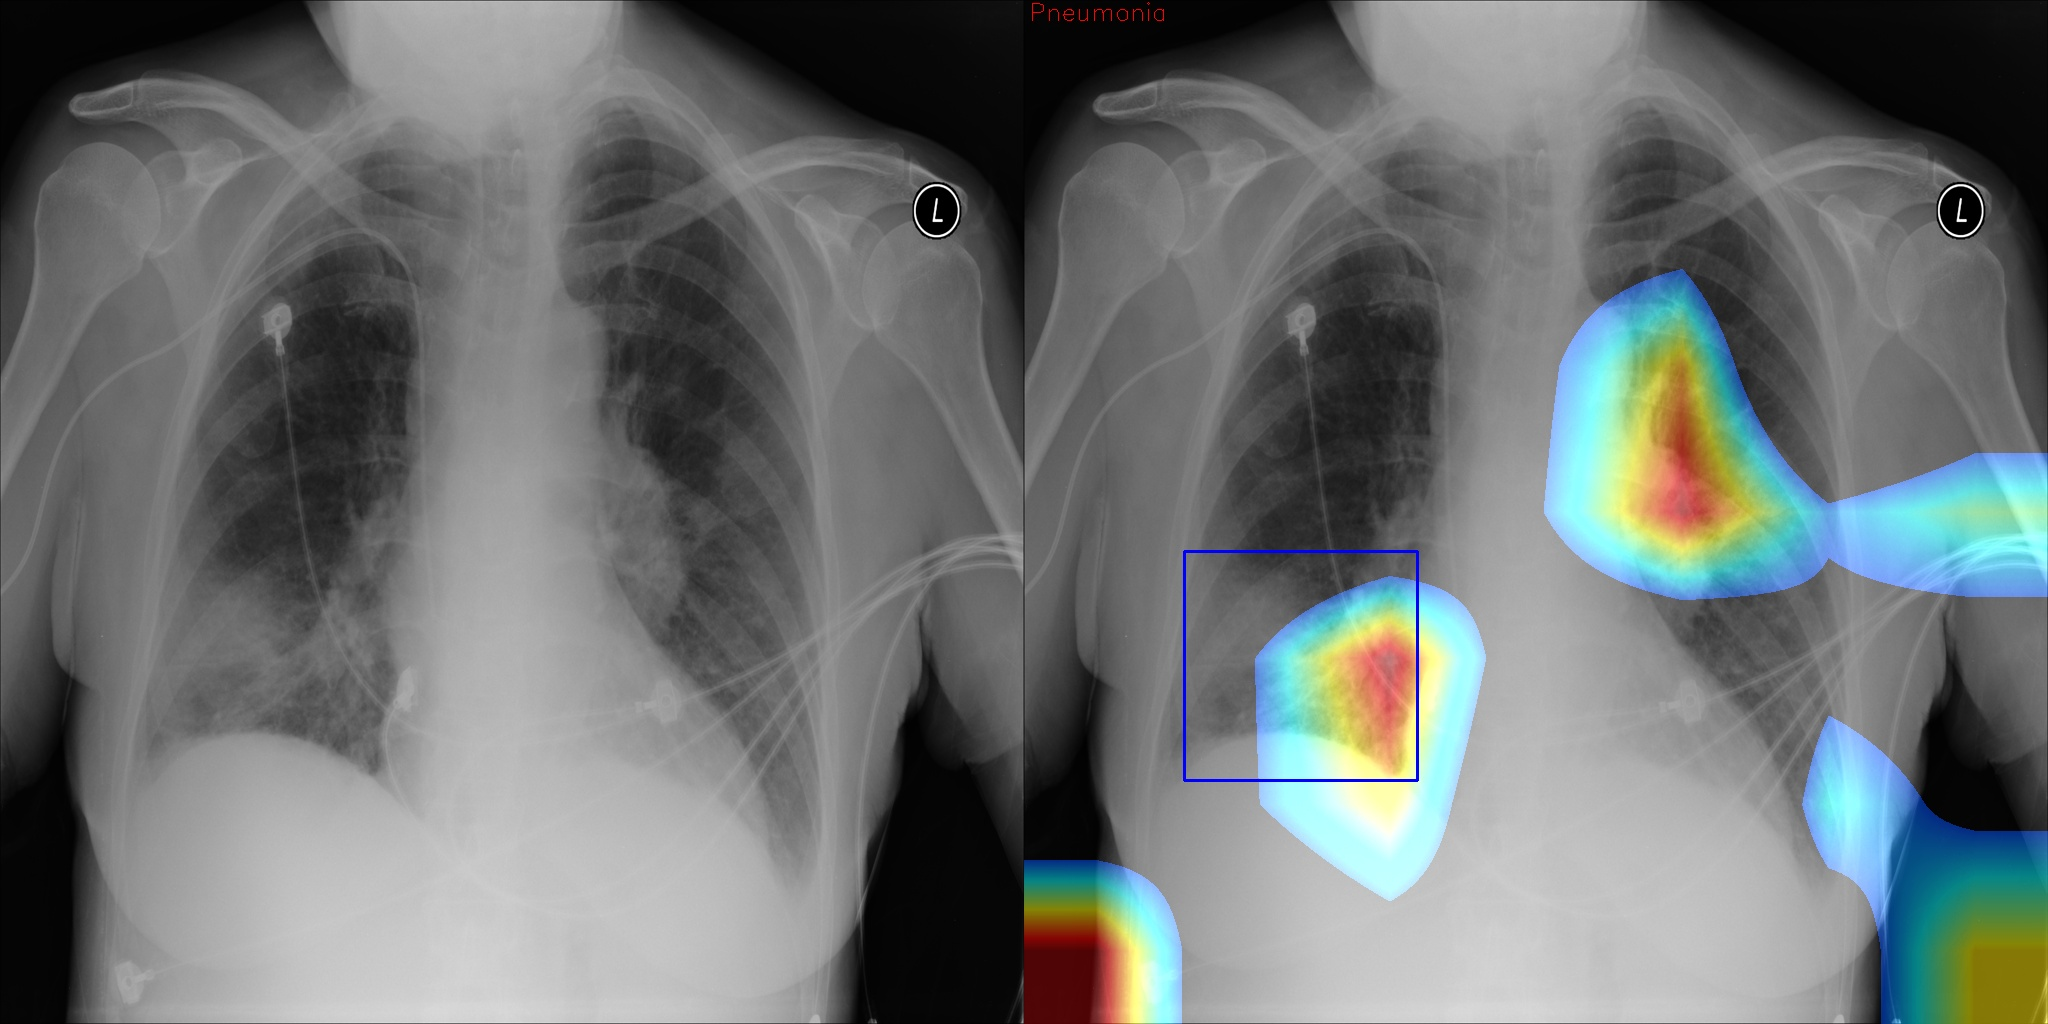

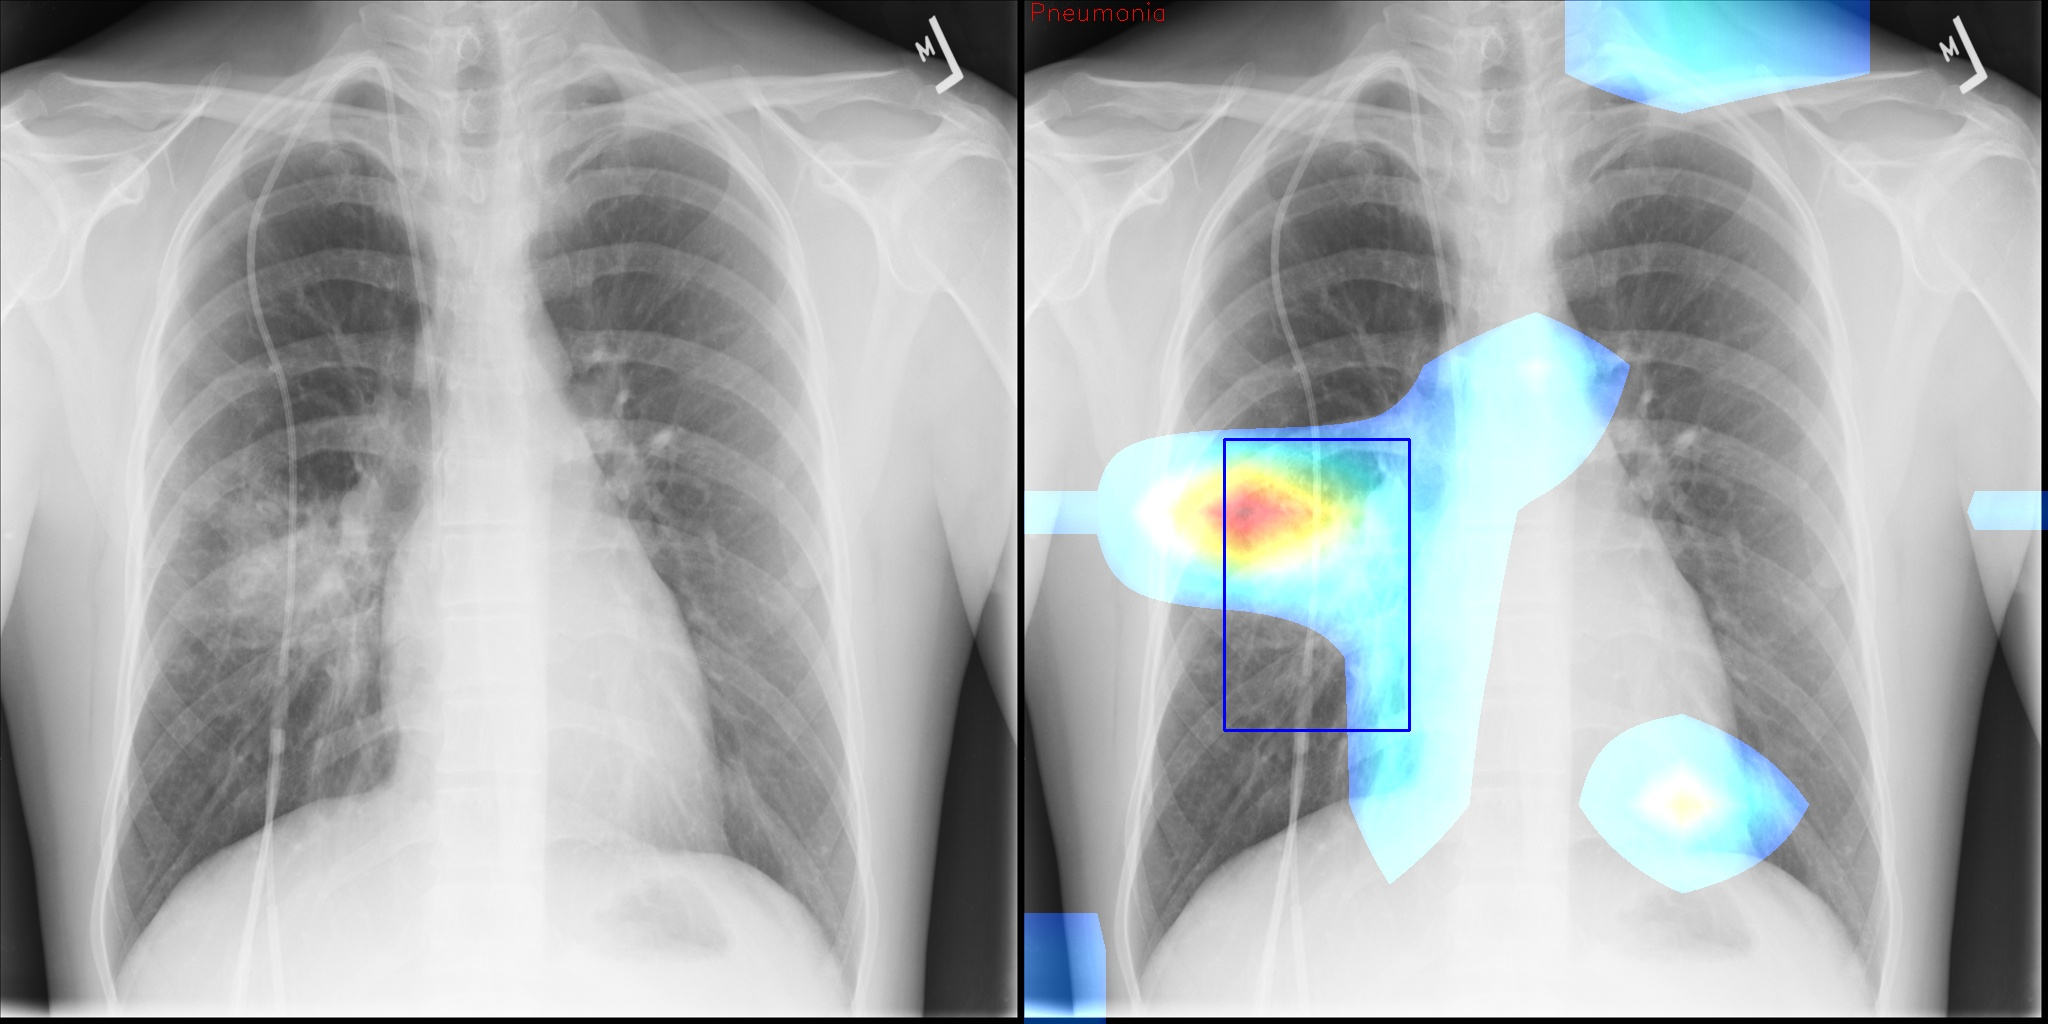

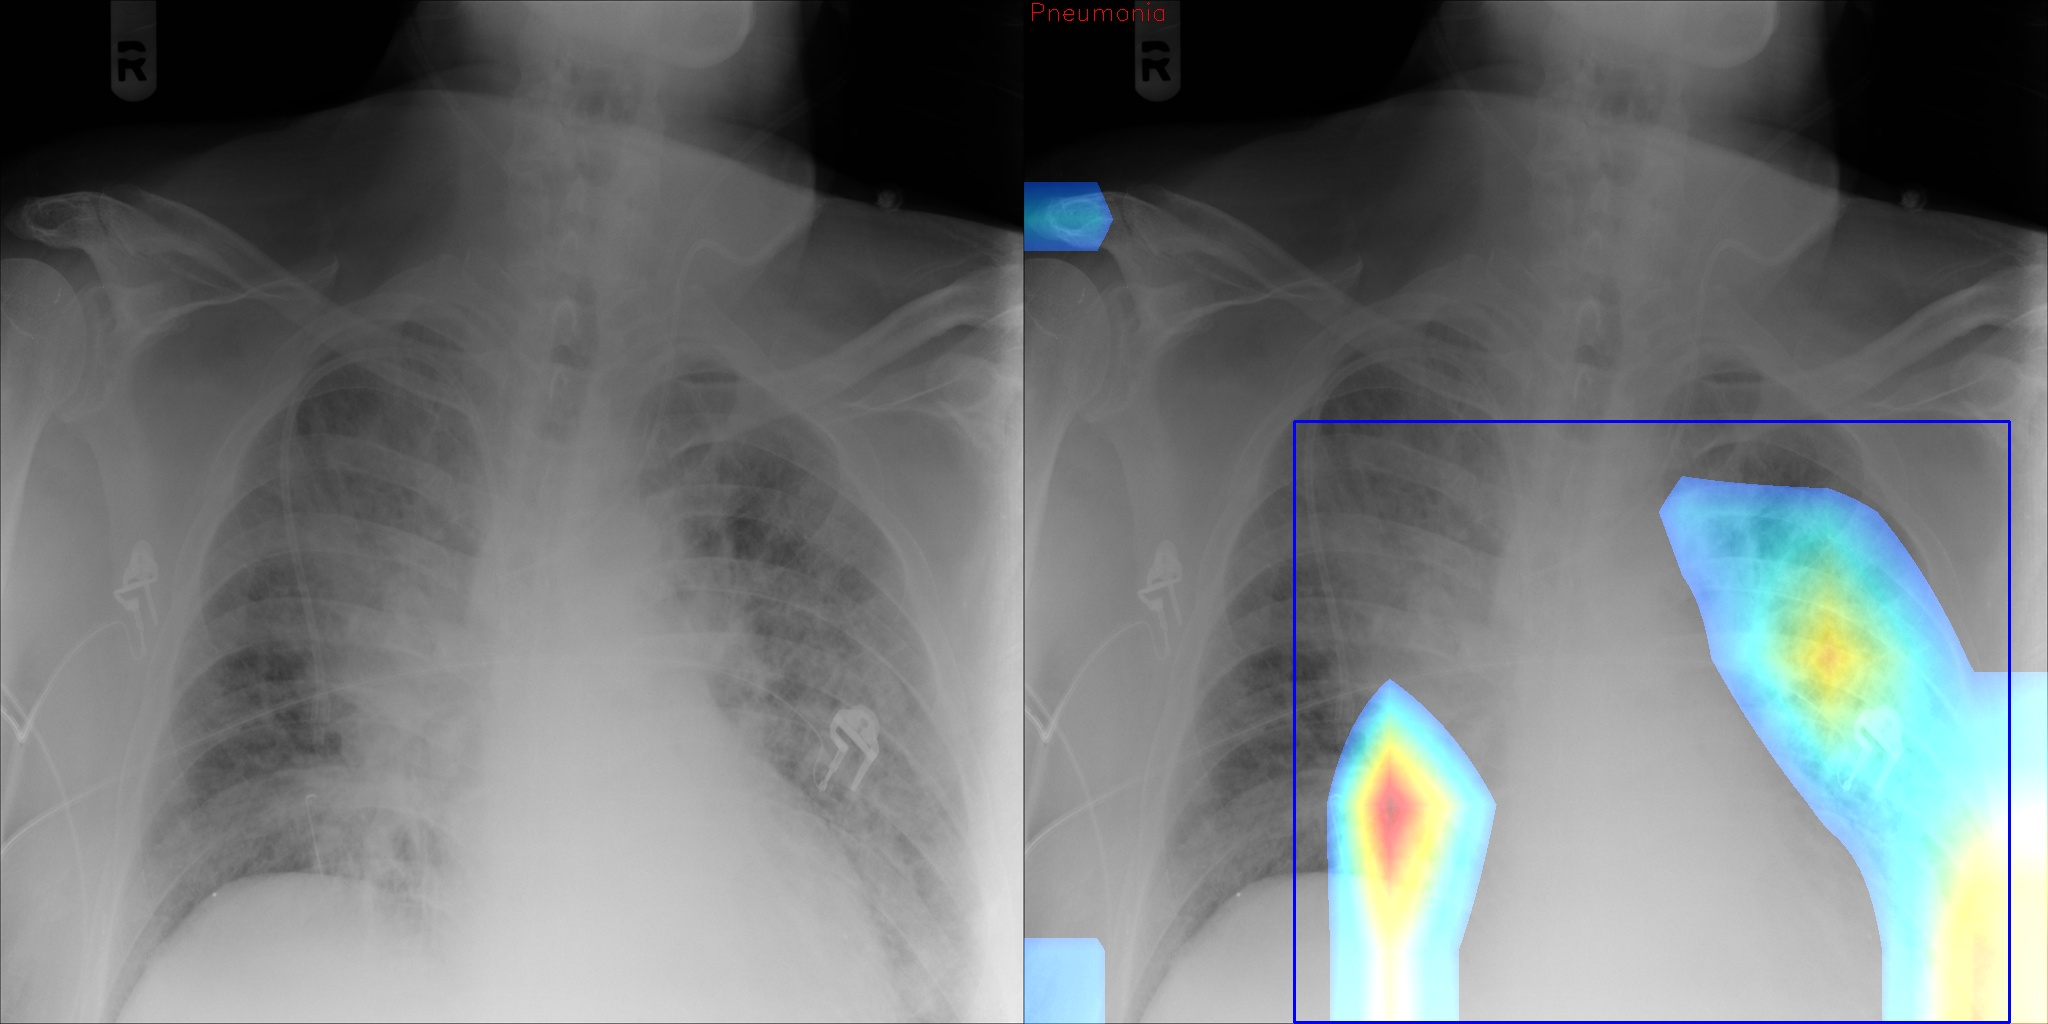

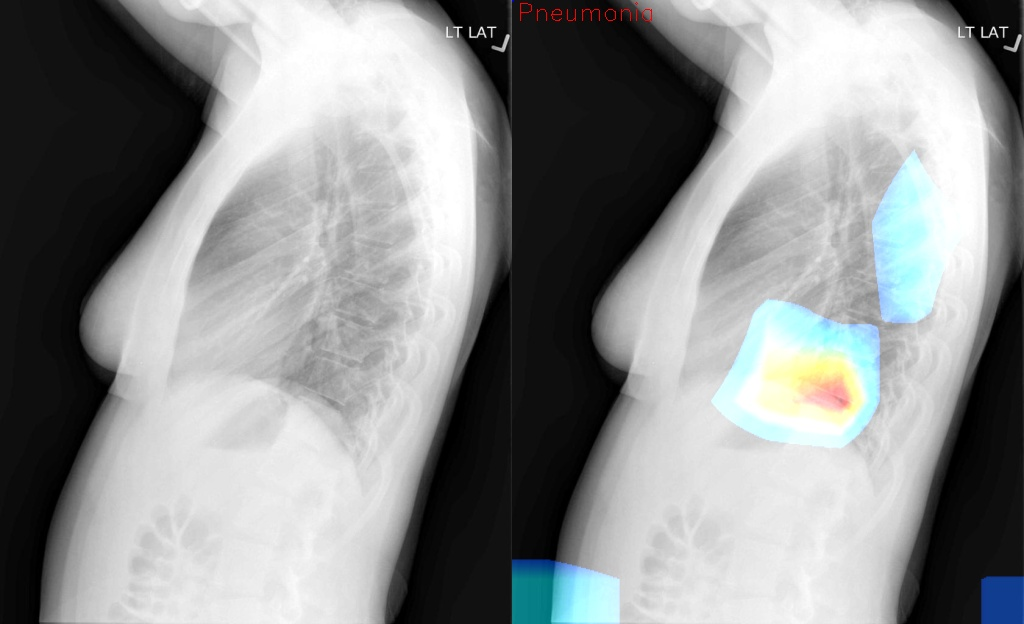

In [3]:
from IPython.display import display, Image
import os

def display_images_from_folder(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    # Filter only image files (assuming jpg format)
    image_files = [file for file in files if file.lower().endswith('.jpg') or file.lower().endswith('.jpeg') or file.lower().endswith('.png')]

    # Display each image one after another
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        display(Image(filename=image_path))

# Example usage
folder_path = "D:\Tapasvi\Projects\Main_Project\CheXNet- Final for gradcam\CheXNet-Keras-master\output"
display_images_from_folder(folder_path)
